# Setup

### Load modules

In [ ]:
# authenication libraries for colab & bigquery tools
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
bigquery.USE_LEGACY_SQL = False

# data processing libraries
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.5f}'.format

from scipy.optimize import least_squares
import datetime
import networkx as nx
from sklearn import preprocessing
from matplotlib import pyplot as plt

# Import Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, VECM
from statsmodels.tsa.stattools import adfuller, coint, grangercausalitytests
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.vector_ar.vecm import coint_johansen, select_coint_rank
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.stats.stattools import durbin_watson
from statsmodels.compat.python import lrange

#adhoc_import.InitializeFromSrcfs() # Plotly uses dynamic imports
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns

# BQ Magics
from google.cloud import bigquery
from google.cloud.bigquery import magics
magics.context.project = 'db' #list BQ project name
client = bigquery.Client(project=magics.context.project)


%load_ext google.cloud.bigquery

#### Define Functions

In [32]:
def get_coeff(X):
  x = 0
  for i in range(0, X.shape[0]):
    x += X[i][0][1]
  return x

def get_factor(Y):
  i = ts[impulse].astype(float).std()
  r  = ts[response].astype(float).std()
  fact = (get_coeff(Y)*r/i)
  return fact

def mape(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    return(mape)


def grangers_causation_matrix(data, variab, maxlag, test='ssr_chi2test', verbose=False):
  df = pd.DataFrame(np.zeros((variab.shape[0], variab.shape[0])), columns=variab, index=variab)
  for c in df.columns:
    for r in df.index:
      test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      df.loc[r, c] = min_p_value
  df.columns = [var + '_cause' for var in variab]
  df.index = [var + '_effect' for var in variab]
  return df

In [33]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [34]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [35]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

# Define Parameters

### Load model input data

In [36]:
%%bigquery df
SELECT *
FROM `db.dataset.table`

In [37]:
df = df[['Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Audio_x_AWA_imps','DBM_x_Display_x_RTG_imps', 'Amazon_x_Display_x_AWA_imps',
         'DBM_x_Video_x_AWA_imps', 'The_Trade_Desk_x_Display_x_AWA_imps', 'Brand_x_RMKT_x_EC_clicks','OTHER_x_Display_x_AWA_imps',
         'Amazon_x_Display_x_RTG_imps', 'DBM_x_Display_x_ACQ_imps','Oath_x_Display_x_AWA_imps', 'DBM_x_Display_x_AWA_imps', 'new_accounts','day']]

In [38]:
df = df.fillna(0)

In [39]:
frequency = "Daily" #@param ["Daily", "Weekly", "Monthly", "Yearly"]
dateName = 'day'  #@param {type:"string"} 

In [40]:
ts = df.drop([dateName], axis = 1)
ts = pd.DataFrame([pd.to_numeric(ts[c]) for c in ts.columns]).transpose()
#ts = ts.reset_index()

if frequency == 'Daily':
  maxlag = 7
elif frequency == 'Weekly':
  maxlag = 4
elif frequency == 'Monthly':
  maxlag = 12
elif frequency == 'Yearly':
  maxlag = 4


# Visualize the time series

In [41]:
# Plot
'''
fig, axes = plt.subplots(nrows=7, ncols=2,  dpi=200, figsize=(7,7))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();
'''

'\nfig, axes = plt.subplots(nrows=7, ncols=2,  dpi=200, figsize=(7,7))\nfor i, ax in enumerate(axes.flatten()):\n    data = df[df.columns[i]]\n    ax.plot(data, color=\'red\', linewidth=1)\n    # Decorations\n    ax.set_title(df.columns[i])\n    ax.xaxis.set_ticks_position(\'none\')\n    ax.yaxis.set_ticks_position(\'none\')\n    ax.spines["top"].set_alpha(0)\n    ax.tick_params(labelsize=6)\n\nplt.tight_layout();\n'

# Pre-Testing 
## Testing Causation using Granger’s Causality Test

5-10% is a good statistical significance threshold for importance assuming there is sufficient length of data (i.e. 2 years).

Otherwise, be flexible and look at 15% but recognize that these varaibles might need further review.

There's also no rule of thumb for the # of lags to include.

In [42]:

grangers_causation_matrix(ts, variab = ts.columns, maxlag = maxlag)        


,Brand_x_Core_x_NC_clicks_cause,The_Trade_Desk_x_Audio_x_AWA_imps_cause,DBM_x_Display_x_RTG_imps_cause,Amazon_x_Display_x_AWA_imps_cause,DBM_x_Video_x_AWA_imps_cause,The_Trade_Desk_x_Display_x_AWA_imps_cause,Brand_x_RMKT_x_EC_clicks_cause,OTHER_x_Display_x_AWA_imps_cause,Amazon_x_Display_x_RTG_imps_cause,DBM_x_Display_x_ACQ_imps_cause,Oath_x_Display_x_AWA_imps_cause,DBM_x_Display_x_AWA_imps_cause,new_accounts_cause
Brand_x_Core_x_NC_clicks_effect,1.00000,0.02580,0.12950,0.02810,0.55470,0.46820,0.00140,0.00170,0.00420,0.01130,0.06440,0.01130,0.67450
The_Trade_Desk_x_Audio_x_AWA_imps_effect,0.01350,1.00000,0.11990,0.03010,0.01060,0.00010,0.00000,0.00000,0.00000,0.09240,0.00000,0.00010,0.01590
DBM_x_Display_x_RTG_imps_effect,0.18150,0.00490,1.00000,0.00830,0.00480,0.25150,0.00110,0.00930,0.01370,0.04820,0.31760,0.00980,0.40070
Amazon_x_Display_x_AWA_imps_effect,0.05720,0.22050,0.53780,1.00000,0.04140,0.13570,0.67060,0.01520,0.00290,0.28790,0.01780,0.17590,0.00150
DBM_x_Video_x_AWA_imps_effect,0.02870,0.00000,0.48860,0.03900,1.00000,0.00000,0.00000,0.00000,0.00000,0.00050,0.00000,0.00000,0.00440
The_Trade_Desk_x_Display_x_AWA_imps_effect,0.29350,0.00000,0.00090,0.01910,0.00010,1.00000,0.00000,0.00000,0.00000,0.00050,0.00000,0.00000,0.14800
Brand_x_RMKT_x_EC_clicks_effect,0.00000,0.00000,0.00240,0.28920,0.00900,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.01320
OTHER_x_Display_x_AWA_imps_effect,0.05770,0.00000,0.38370,0.04420,0.04900,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.20090
Amazon_x_Display_x_RTG_imps_effect,0.00810,0.00000,0.47930,0.05640,0.36540,0.00530,0.00000,0.00000,1.00000,0.08980,0.00000,0.01190,0.29680
DBM_x_Display_x_ACQ_imps_effect,0.00100,0.00000,0.23420,0.26220,0.10900,0.00140,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00240


Format  for running Granger Causality test at significance levels and lags

In [43]:
#@title Run Granger Causality Test  {run: 'auto'}
significance_level = 0.05 #@param {type:"slider", min:0, max:0.3, step:0.001}
lag = 5        #@param {type:'integer'} 



In [44]:
gc = grangers_causation_matrix(ts, ts.columns, maxlag = lag)

gc1 = gc.stack().reset_index().rename(columns = {"level_0":"effect", "level_1":"cause", 0:"causation?"})
gc1['causation?'] = gc1['causation?'].apply(lambda x: 1 if x <= significance_level else 0)
gc1 = gc1.pivot(index = 'cause', columns = 'effect', values = 'causation?')

G = nx.from_numpy_matrix(gc1.values, 
                         parallel_edges=True, 
                         create_using=nx.DiGraph())

label_mapping = pd.Series(ts.columns, list(range(0, gc1.index.size))).to_dict()
G = nx.relabel_nodes(G, label_mapping)

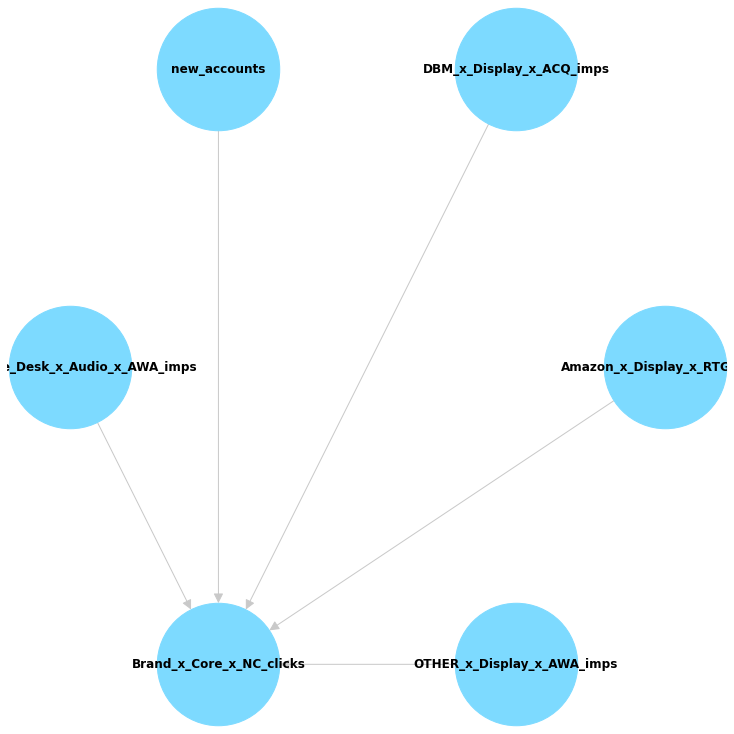

In [45]:
#@title Explore Granger Causality Graphs  {run: 'auto'}
CausalDirection = "In" #@param ["In", "Out"]
Variable ="Brand_x_Core_x_NC_clicks"  #@param {type:"string"}

if CausalDirection == 'In':
  Graph = G.in_edges([Variable])
else:
  Graph = G.out_edges([Variable])

H = nx.from_edgelist(Graph, 
                     create_using=nx.DiGraph())
plt.figure(figsize =(10, 10))

#the color & size of the cause or effect should be different than the rest
# https://stackoverflow.com/questions/27030473/how-to-set-colors-for-nodes-in-networkx
#dim other nodes
nx.draw_shell(H, 
              arrows=True, 
              with_labels=True,
              arrowsize=20, 
              # arrowstyle='simple',
              font_color = 'black',
              font_weight = 'bold',
              node_color = '#7ddaff',
              node_size = 15000,
              width = 1,
              edge_color = '#c9c9c9')

# Variable Selection

Criteria for selecting variables:
- Granger causality
- Use 1 metric per channel (cost, views, impressions, clicks): use business sense or VIF to determine the best metric per channel
- Metrics do not have to be the same across tactics


- Cost usually doesn't come up as significant because there is too much backward looking behavior

In [46]:
ts.columns.tolist()

['Brand_x_Core_x_NC_clicks',
 'The_Trade_Desk_x_Audio_x_AWA_imps',
 'DBM_x_Display_x_RTG_imps',
 'Amazon_x_Display_x_AWA_imps',
 'DBM_x_Video_x_AWA_imps',
 'The_Trade_Desk_x_Display_x_AWA_imps',
 'Brand_x_RMKT_x_EC_clicks',
 'OTHER_x_Display_x_AWA_imps',
 'Amazon_x_Display_x_RTG_imps',
 'DBM_x_Display_x_ACQ_imps',
 'Oath_x_Display_x_AWA_imps',
 'DBM_x_Display_x_AWA_imps',
 'new_accounts']

In [47]:
#@title Choose Variables For The Model (Paste)
variables = ['Brand_x_Core_x_NC_clicks',
 'The_Trade_Desk_x_Audio_x_AWA_imps',
 'DBM_x_Display_x_RTG_imps',
 'Amazon_x_Display_x_AWA_imps',
 'DBM_x_Video_x_AWA_imps',
 'The_Trade_Desk_x_Display_x_AWA_imps',
 'Brand_x_RMKT_x_EC_clicks',
 'OTHER_x_Display_x_AWA_imps',
 'Amazon_x_Display_x_RTG_imps',
 'DBM_x_Display_x_ACQ_imps',
 'Oath_x_Display_x_AWA_imps',
 'DBM_x_Display_x_AWA_imps',
 'new_accounts']

#DO NOT EDIT CODE BELOW
ts = ts[variables]
ts[variables] = ts[variables].apply(pd.to_numeric, errors = 'coerce')

## Stationarity and Cointegration Tests

ADF Tests

In [48]:
#Tests for Stationarity
regressionDictionary = {
    'c'  : 'Constant',
    'ct' : 'Constant with Trend',
    'ctt': 'Constant with Linear and Quadratic Trend',
    'nc' : 'No Constant / No Trend'
    }

data = pd.DataFrame([0 if round(adfuller(ts[c], maxlag=maxlag, regression='c')[1], 5)   < 0.1 else 1 for c in ts.columns], columns=['c'], index=ts.columns).join(
       pd.DataFrame([0 if round(adfuller(ts[c], maxlag=maxlag, regression='ct')[1], 5)  < 0.1 else 1 for c in ts.columns], columns=['ct'], index=ts.columns)).join(
       pd.DataFrame([0 if round(adfuller(ts[c], maxlag=maxlag, regression='ctt')[1], 5) < 0.1 else 1 for c in ts.columns], columns=['ctt'], index=ts.columns)).join(
       pd.DataFrame([0 if round(adfuller(ts[c], maxlag=maxlag, regression='nc')[1], 5)  < 0.1 else 1 for c in ts.columns], columns=['nc'], index=ts.columns))
dt = pd.DataFrame(data = data.sum(), columns = ['unit roots'])

roots   = dt[dt['unit roots'] == data.sum().min()]['unit roots'][0]
regress = dt[dt['unit roots'] == data.sum().min()].index[0]


In [49]:
roots

0

In [50]:
if (roots == 0):
  print('No Unit Roots present')
else:
  print('Unit Roots present')
  print('First-differencing the data')
  df = df.diff().dropna()
  print('.......................')
  print('Re-testing for unit roots')
  print('........................')
  data = pd.DataFrame([0 if round(adfuller(df[c], maxlag=maxlag, regression='c')[1], 5)   < 0.1 else 1 for c in df.columns], columns=['c'], index=df.columns).join(
      pd.DataFrame([0 if round(adfuller(df[c], maxlag=maxlag, regression='ct')[1], 5)  < 0.1 else 1 for c in df.columns], columns=['ct'], index=df.columns)).join(
      pd.DataFrame([0 if round(adfuller(df[c], maxlag=maxlag, regression='ctt')[1], 5) < 0.1 else 1 for c in df.columns], columns=['ctt'], index=df.columns)).join(
      pd.DataFrame([0 if round(adfuller(df[c], maxlag=maxlag, regression='nc')[1], 5)  < 0.1 else 1 for c in df.columns], columns=['nc'], index=df.columns))
  dt = pd.DataFrame(data = data.sum(), columns = ['unit roots'])

  roots   = dt[dt['unit roots'] == data.sum().min()]['unit roots'][0]
  if (roots ==0):
    print('No Unit Roots present')
  else:
    print('Unit Roots still present')

No Unit Roots present


**Cointegration** test helps to establish the presence of a statistically significant connection between two or more time series.

If no co-integration exists we can use the VAR model. If co-integration does exist, we have to use the VECM model.

You can also drop one co-integrated variable and run the VAR model (this depends on the use case).

Another way to test for co-integration is to regress one variable on another and check the residuals. If the residuals are stationary, the two series are co-integrated.

In [51]:
cointegration_test(ts)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Brand_x_Core_x_NC_clicks ::  664.95    > nan       =>   False
The_Trade_Desk_x_Audio_x_AWA_imps ::  541.38    > 311.1288  =>   True
DBM_x_Display_x_RTG_imps ::  424.07    > 263.2603  =>   True
Amazon_x_Display_x_AWA_imps ::  334.25    > 219.4051  =>   True
DBM_x_Video_x_AWA_imps ::  251.96    > 179.5199  =>   True
The_Trade_Desk_x_Display_x_AWA_imps ::  186.08    > 143.6691  =>   True
Brand_x_RMKT_x_EC_clicks ::  123.46    > 111.7797  =>   True
OTHER_x_Display_x_AWA_imps ::  84.71     > 83.9383   =>   True
Amazon_x_Display_x_RTG_imps ::  54.47     > 60.0627   =>   False
DBM_x_Display_x_ACQ_imps ::  35.37     > 40.1749   =>   False
Oath_x_Display_x_AWA_imps ::  18.02     > 24.2761   =>   False
DBM_x_Display_x_AWA_imps ::  4.09      > 12.3212   =>   False
new_accounts ::  0.27      > 4.1296    =>   False


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/vector_ar/vecm.py:608: HypothesisTestWarning:

Critical values are only available for time series with 12 variables at most.



In [52]:
#Test for Cointegration
coint = pd.DataFrame([[round(coint(ts[i], ts[j], trend = 'c')[1], 3) for i in ts.columns] for j in ts.columns], columns=ts.columns, index=ts.columns)
coint = pd.melt(coint, value_vars=coint.columns, value_name = 'p_value', ignore_index = False).reset_index()
cointVars = coint[(coint['p_value'] <= 0.1) & (coint['index'] != coint['variable'])]
cointVarsCount = cointVars.shape[0]  

#Cointegrating Relationships
cointRelationships=select_coint_rank(endog = ts, det_order = 1, k_ar_diff = 1).rank

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1432: CollinearityWarning:

y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1432: CollinearityWarning:

y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1432: CollinearityWarning:

y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1432: CollinearityWarning:

y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1432: CollinearityWarning:

y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statt

In [53]:
if (cointVarsCount == 0):
  print('No Cointegration')
else:
  print('Cointegration present')

if (cointRelationships == 0):
  print('No Cointegrating relationships')
else:
  print({cointRelationships}, 'Cointegrating relationships')

Cointegration present
{13} Cointegrating relationships


# Run VAR Model

In [54]:
#Run Model
if (roots == 0):
  var = VAR(ts)
#  model = var.fit(maxlags=maxlag, ic='aic', trend = regress)
  model = var.fit()
else:
  vecm = VECM(endog=df, k_ar_diff=1, coint_rank=cointRelationships)
  model = vecm.fit()

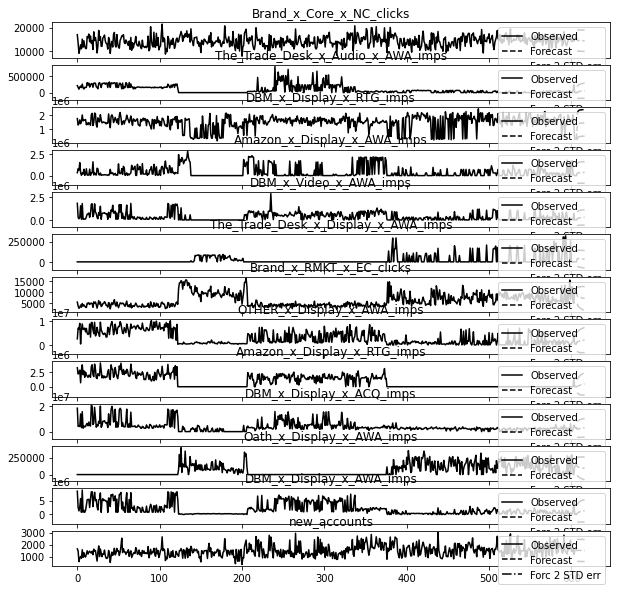

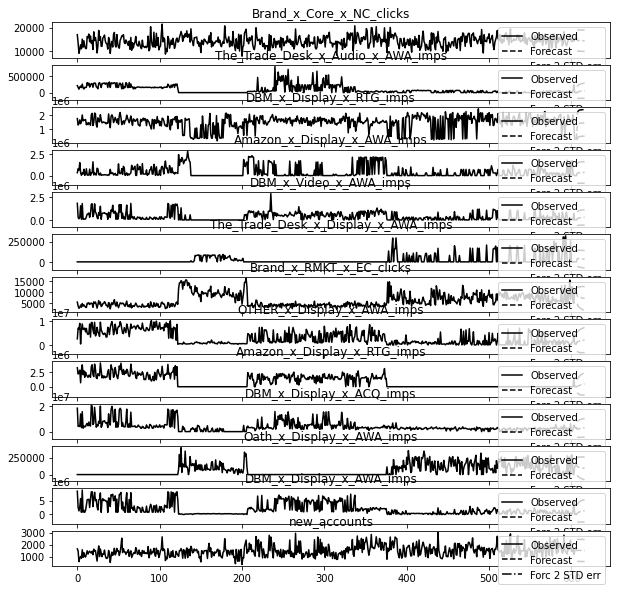

In [55]:
model.plot_forecast(10)

In [56]:
model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 22, Sep, 2021
Time:                     21:01:23
--------------------------------------------------------------------
No. of Equations:         13.0000    BIC:                    297.539
Nobs:                     606.000    HQIC:                   296.730
Log likelihood:          -100750.    FPE:               4.41315e+128
AIC:                      296.215    Det(Omega_mle):    3.27945e+128
--------------------------------------------------------------------
Results for equation Brand_x_Core_x_NC_clicks
                                            coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------------
const                                      12806.198572       701.028513           18.268           0.000
L1.Brand_x_Core_x_NC_clicks                    

# Results

In [57]:
#@title Summarize Results {run: 'auto'}
response_period = 7        #@param {type:'integer'} 

periods = response_period
model = model
orth = True
svar = False

#IRF object
irf = model.irf(periods)
neqs = model.neqs
rng = lrange(neqs)

#non cumulative IRF
irfs = irf.orth_irfs
stderr = np.array(irf.errband_mc(orth=orth, svar=svar, repl=1000, signif=0.05, seed=None, burn = 100))

#cumulative IRF
irfs_cum = irf.orth_cum_effects
stderr_cum = np.array(irf.cum_errband_mc(orth=orth, repl=1000, signif=0.05, seed=None, burn = 100))

#fevd (for VAR only)
irfs2 = (irfs[:periods] ** 2).cumsum(axis=0)
mse = model.mse(periods)[:, rng, rng]
fevd = np.empty_like(irfs)
for i in range(periods): 
  fevd[i] = (irfs2[i].T / mse[i]).T

decomp = fevd.swapaxes(0, 1)

#Summarize results into dataframe
df = pd.DataFrame()
for i in range(0, irfs.shape[1]):
  for r in range(0, irfs.shape[2]):
    len = irfs.shape[0]
    tab = pd.DataFrame([irfs[n][r][i] for n in range(0, irfs.shape[0])], columns=['irf'])
    tab2= pd.DataFrame([stderr[0][n][r][i] for n in range(0, stderr.shape[1])], columns=['irf stderr lower bound'])
    tab3= pd.DataFrame([stderr[1][n][r][i] for n in range(0, stderr.shape[1])], columns=['irf stderr upper bound'])    
    tab4= pd.DataFrame([irfs_cum[n][r][i] for n in range(0, irfs_cum.shape[0])], columns=['cumulative irf'])
    tab5= pd.DataFrame([stderr_cum[0][n][r][i] for n in range(0, stderr_cum.shape[1])], columns=['cumulative irf stderr lower bound'])
    tab6= pd.DataFrame([stderr_cum[1][n][r][i] for n in range(0, stderr_cum.shape[1])], columns=['cumulative irf stderr upper bound'])
    tab7= pd.DataFrame([fevd[n][r][i] for n in range(0, fevd.shape[0])], columns=['fevd'])
    imp = pd.DataFrame(np.tile(model.names[r],(tab.shape[0],1)), columns=['response'])
    res = pd.DataFrame(np.tile(model.names[i],(tab.shape[0],1)), columns=['impulse'])
    num = pd.DataFrame(np.arange(1, tab.shape[0]+1), columns=['n'])
    df  = df.append(tab.join(tab2).join(tab3).join(tab4).join(tab5).join(tab6).join(tab7).join(imp).join(res).join(num))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/vector_ar/irf.py:642: FutureWarning:

the 'T'' keyword is deprecated, use 'steps' instead



## IRFs

IRFs are interpreted as a 1 sd increase impact on another variable's response

Top-left fig:
- A one standard deviation change in brand search clicks (i.e. 3000 incremental clicks) at time t will show how brand search clicks will respond in the follow periods

Right-hand side figures show the cumulative effect of the impulse respond. An additional 3K incremental clicks today resultsi n over 6K clicks 14 periods out

In [58]:
 #@title Explore Dynamic Incrementality {run: 'auto'}
impulse="Brand_x_Core_x_NC_clicks"  #@param {type:"string"}
response="new_accounts" #@param {type:"string"}
impulse_name="Brand Clicks"  #@param {type:"string"}
response_name = "Conversions" #@param {type:"string"}


sub = df[((df['response']==response)) & (df['impulse']==impulse)][['n', 'irf', 'irf stderr lower bound', 'irf stderr upper bound', 'cumulative irf', 'cumulative irf stderr lower bound', 'cumulative irf stderr upper bound']]
sub2= df[((df['response']==impulse)) & (df['impulse']==impulse)][['n', 'irf', 'irf stderr lower bound', 'irf stderr upper bound', 'cumulative irf', 'cumulative irf stderr lower bound', 'cumulative irf stderr upper bound']]

title1 = "One Time Effects: {} -> {}".format(impulse_name, impulse_name)
title2 = "Cumulative Effects: {} -> {}".format(impulse_name, impulse_name)
title3 = "One Time Effects: {} -> {}".format(impulse_name, response_name)
title4 = "Cumulative Effects: {} -> {}".format(impulse_name, response_name)

fig = make_subplots(rows=2, cols=2, subplot_titles=(title1, title2, title3, title4))
fig.add_trace(go.Scatter(x=sub['n'], y=sub2['irf'], name = 'Impulse Response Function', line = dict(color='royalblue', width=4)), row=1, col=1)
fig.add_trace(go.Scatter(x=sub['n'], y=sub2['irf stderr lower bound'], name = 'Standard Error Lower Bound', line = dict(color='royalblue', width=4, dash = 'dash')), row=1, col=1)
fig.add_trace(go.Scatter(x=sub['n'], y=sub2['irf stderr upper bound'], name = 'Standard Error Upper Bound', line = dict(color='royalblue', width=4, dash = 'dash')), row=1, col=1)

fig.add_trace(go.Scatter(x=sub['n'], y=sub2['cumulative irf'], name = 'Cumulative Impulse Response Function', line = dict(color='royalblue', width=4)), row=1, col=2)
fig.add_trace(go.Scatter(x=sub['n'], y=sub2['cumulative irf stderr lower bound'], name = 'Cumulative Standard Error Lower Bound', line = dict(color='royalblue', width=4, dash = 'dash')), row=1, col=2)
fig.add_trace(go.Scatter(x=sub['n'], y=sub2['cumulative irf stderr upper bound'], name = 'Cumulative Standard Error Upper Bound', line = dict(color='royalblue', width=4, dash = 'dash')), row=1, col=2)

fig.add_trace(go.Scatter(x=sub['n'], y=sub['irf'], name = 'Impulse Response Function', line = dict(color='royalblue', width=4)), row=2, col=1)
fig.add_trace(go.Scatter(x=sub['n'], y=sub['irf stderr lower bound'], name = 'Standard Error Lower Bound', line = dict(color='royalblue', width=4, dash = 'dash')), row=2, col=1)
fig.add_trace(go.Scatter(x=sub['n'], y=sub['irf stderr upper bound'], name = 'Standard Error Upper Bound', line = dict(color='royalblue', width=4, dash = 'dash')), row=2, col=1)

fig.add_trace(go.Scatter(x=sub['n'], y=sub['cumulative irf'], name = 'Cumulative Impulse Response Function', line = dict(color='royalblue', width=4)), row=2, col=2)
fig.add_trace(go.Scatter(x=sub['n'], y=sub['cumulative irf stderr lower bound'], name = 'Cumulative Standard Error Lower Bound', line = dict(color='royalblue', width=4, dash = 'dash')), row=2, col=2)
fig.add_trace(go.Scatter(x=sub['n'], y=sub['cumulative irf stderr upper bound'], name = 'Cumulative Standard Error Upper Bound', line = dict(color='royalblue', width=4, dash = 'dash')), row=2, col=2)
fig.update_layout(title='Impulse Response Analysis', height=800, width=1800, showlegend=False)

fig.show()

## Forecast Decomposition

In [59]:
model.resid.columns

Index(['Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Audio_x_AWA_imps',
       'DBM_x_Display_x_RTG_imps', 'Amazon_x_Display_x_AWA_imps',
       'DBM_x_Video_x_AWA_imps', 'The_Trade_Desk_x_Display_x_AWA_imps',
       'Brand_x_RMKT_x_EC_clicks', 'OTHER_x_Display_x_AWA_imps',
       'Amazon_x_Display_x_RTG_imps', 'DBM_x_Display_x_ACQ_imps',
       'Oath_x_Display_x_AWA_imps', 'DBM_x_Display_x_AWA_imps',
       'new_accounts'],
      dtype='object')

In [60]:
#@title Explore Dynamic Attribution/Contribution Analysis {run: 'auto'}
variables = "new_accounts" #@param {type: "string"}
variable_name = "Total Conversions" #@param {type:"string"}
title5 = "Dynamic Contribution to {} Analysis".format(variable_name)

fvd = df[(df['response']==variables) & (df['n']<16)][['n', 'impulse', 'fevd']]

fig = px.area(fvd, x='n', y='fevd', color='impulse',
              labels = {
                  "n":"Forecast Period",
                  "impulse": "Contributor",
                  "fevd": "Contribution"
              })
fig.update_layout(title=title5, height=600, width=1200)
fig.show()

# Post Model Tests

Whiteness of residuals - absence of significant residual autocorrelations

In [61]:
model.test_whiteness().summary()

Test statistic,Critical value,p-value,df
2486.,1613.,0.000,1521


Normality of residuals:
null hypothesis that the data is normally distributed

In [62]:
model.resid.columns

Index(['Brand_x_Core_x_NC_clicks', 'The_Trade_Desk_x_Audio_x_AWA_imps',
       'DBM_x_Display_x_RTG_imps', 'Amazon_x_Display_x_AWA_imps',
       'DBM_x_Video_x_AWA_imps', 'The_Trade_Desk_x_Display_x_AWA_imps',
       'Brand_x_RMKT_x_EC_clicks', 'OTHER_x_Display_x_AWA_imps',
       'Amazon_x_Display_x_RTG_imps', 'DBM_x_Display_x_ACQ_imps',
       'Oath_x_Display_x_AWA_imps', 'DBM_x_Display_x_AWA_imps',
       'new_accounts'],
      dtype='object')

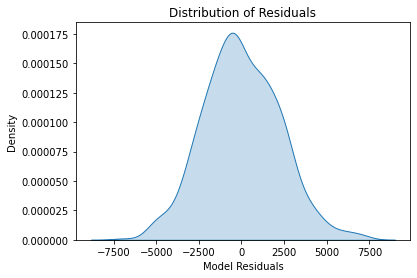

In [63]:
sns.kdeplot(model.resid.Brand_x_Core_x_NC_clicks, label = '', shade = True)
plt.xlabel('Model Residuals'); plt.ylabel('Density'); plt.title('Distribution of Residuals');

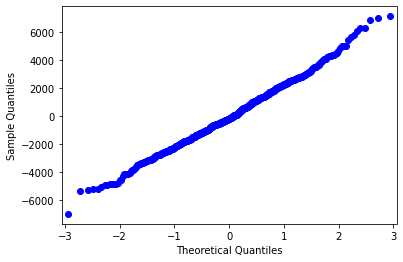

In [64]:
fig = sm.qqplot(model.resid.Brand_x_Core_x_NC_clicks)

In [65]:
model.test_normality().summary()

Test statistic,Critical value,p-value,df
7615.,38.89,0.000,26
